In [74]:
import pandas as pd
import re
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

sns.set_context('poster')
sns.set(rc={'figure.figsize': (14., 8.)})
sns.set_style('whitegrid')

In [2]:
consumos = pd.read_csv("measurements.csv")

# 1. Data cleaning 

First we are going to review the data

In [3]:
consumos.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [4]:
consumos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    int64 
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    int64 
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    int64 
 8   rain           388 non-null    int64 
 9   sun            388 non-null    int64 
 10  refill liters  13 non-null     object
 11  refill gas     13 non-null     object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


In [5]:
consumos.describe()

,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


There are several numeric columns that are categorized as object, let's change the comma to point and convert them to float

In [6]:
consumos.distance = consumos.distance.apply(lambda x: re.sub(',','.', x))

In [7]:
consumos.distance = pd.to_numeric(consumos.distance)

In [8]:
consumos.consume = consumos.consume.apply(lambda x: re.sub(',','.', x))
consumos.consume = pd.to_numeric(consumos.consume)

In [9]:
consumos.temp_inside = consumos.temp_inside.astype('str').apply(lambda x: x.replace(',','.'))
consumos.temp_inside = pd.to_numeric(consumos.temp_inside, errors='coerce')

In [10]:
consumos.temp_inside = consumos.temp_inside.fillna(consumos.temp_inside.median())

In [11]:
consumos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   consume        388 non-null    float64
 2   speed          388 non-null    int64  
 3   temp_inside    388 non-null    float64
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill liters  13 non-null     object 
 11  refill gas     13 non-null     object 
dtypes: float64(3), int64(5), object(4)
memory usage: 36.5+ KB


In [16]:
consumos.rename(columns={'refill liters':'refill_liters', 'refill gas':'refill_gas'},inplace=True)

In [17]:
consumos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   consume        388 non-null    float64
 2   speed          388 non-null    int64  
 3   temp_inside    388 non-null    float64
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill_liters  13 non-null     object 
 11  refill_gas     13 non-null     object 
dtypes: float64(3), int64(5), object(4)
memory usage: 39.4+ KB


In [18]:
consumos.refill_liters = pd.to_numeric(consumos.refill_liters, errors='coerce')

Now we are going to fill the null values

In [19]:
consumos.specials.unique()

array([nan, 'AC rain', 'AC', 'rain', 'snow', 'AC snow',
       'half rain half sun', 'sun', 'AC sun', 'sun ac', 'ac', 'AC Sun',
       'ac rain'], dtype=object)

In [28]:
consumos['snow'] = [1 if re.match('snow',x) else 0 for x in consumos.specials.astype('str')]

In [33]:
consumos.drop(['specials', 'refill_liters', 'refill_gas'], axis=1, inplace=True)

In [34]:
consumos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 387
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   distance      388 non-null    float64
 1   consume       388 non-null    float64
 2   speed         388 non-null    int64  
 3   temp_inside   388 non-null    float64
 4   temp_outside  388 non-null    int64  
 5   gas_type      388 non-null    object 
 6   AC            388 non-null    int64  
 7   rain          388 non-null    int64  
 8   sun           388 non-null    int64  
 9   snow          388 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 41.4+ KB


In [49]:
consumos.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,snow
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.931701,11.358247,0.077320,0.123711,0.082474,0.007732
std,22.667837,1.033172,13.598524,0.994741,6.991542,0.267443,0.329677,0.275441,0.087704
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
consumos['liters'] = consumos.distance*consumos.consume

In [53]:
consumos.gas_type.unique()

array(['E10', 'SP98'], dtype=object)

# 2. Visual exploration

#### Lets explore how cars consume based on the other parameters. Then we will try to build a model to predict this comsume

In [38]:

def heatmap(x):
    """
    This function creates a heatmap from a dataframe given
    """
    corr = x.corr()
    mascara = np.triu(np.ones_like(corr, dtype=bool)) # generamos la máscara para la triangular superior
    color_map = sns.diverging_palette(0, 10, as_cmap=True) # paleta de colores
    return sns.heatmap(corr,  
                mask = mascara,
                cmap='viridis',
                square=True, #que los datos se vean como cuadrados
                linewidth=0.5, #ancho de línea
                vmax=1,
                cbar_kws={"shrink": .5}, #barra lateral,
                annot=True
            )



<AxesSubplot:>

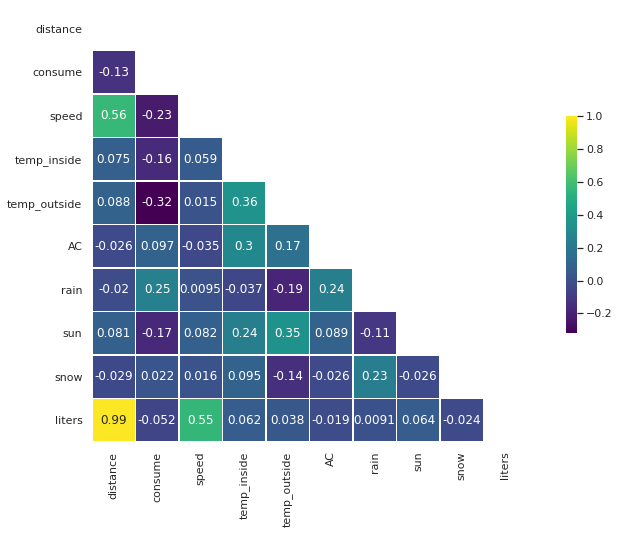

In [52]:
heatmap(consumos)

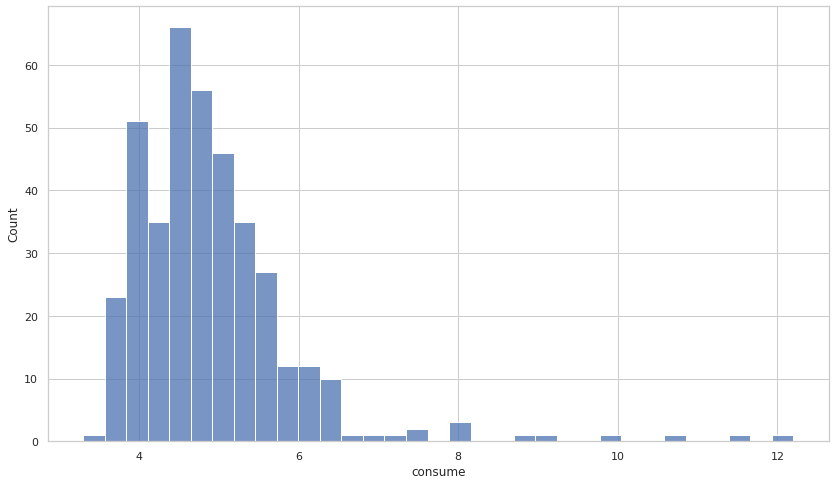

In [43]:
sns.histplot(consumos.consume);

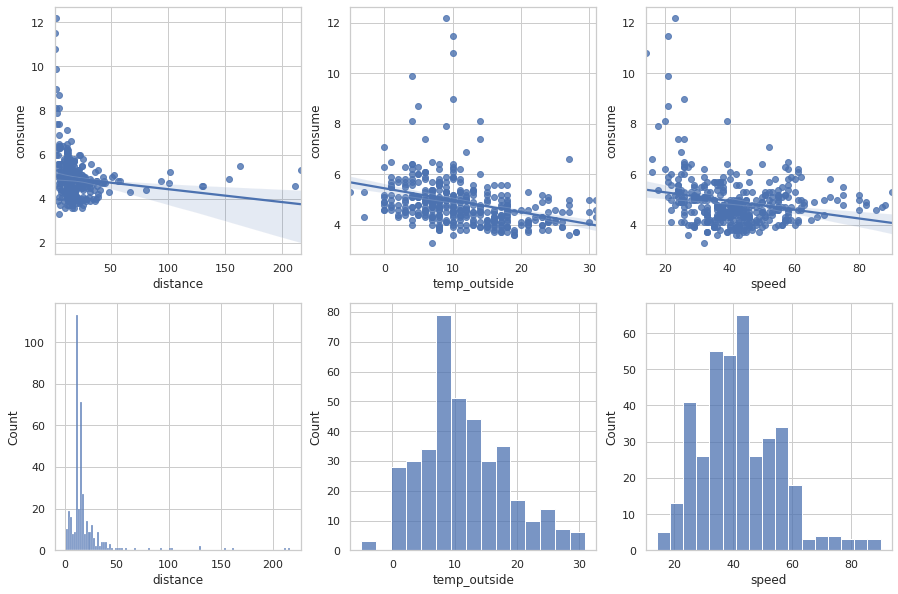

In [64]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
sns.regplot(data=consumos, x='distance', y='consume', ax = axs[0,0]);
sns.regplot(data=consumos, x='temp_outside', y='consume', ax=axs[0,1]);
sns.regplot(data=consumos, x='speed', y='consume', ax = axs[0,2]);
sns.histplot(consumos.distance, ax=axs[1,0]);
sns.histplot(consumos.temp_outside, ax=axs[1,1]);
sns.histplot(consumos.speed, ax=axs[1,2]);


# 3. Machine learning

In [65]:
X = consumos.drop(columns=['consume'])
y = consumos.consume

<AxesSubplot:>

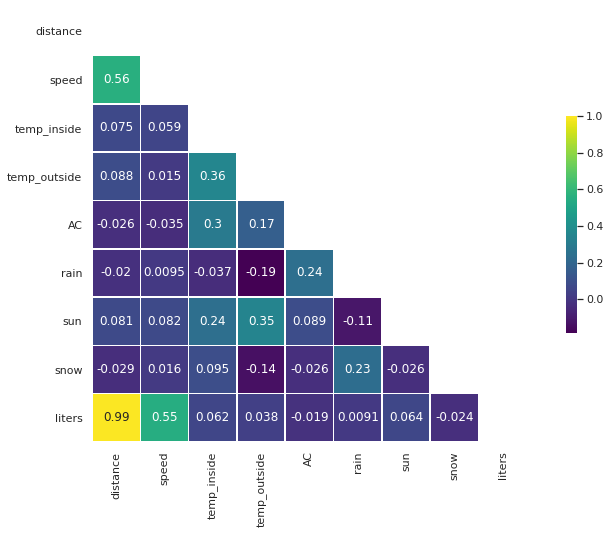

In [68]:
heatmap(X)

We can drop 'distance' column because it can be explained by 'liters' column

In [78]:
X = X.drop(columns=['distance'])


In [81]:
X.gas_type = [0 if x=='E10' else 1 for x in X.gas_type]

In [82]:
X

,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,snow,liters
0,28.0,26,21.5,12,0,0,0,0,0,140.00
1,12.0,30,21.5,13,0,0,0,0,0,50.40
2,11.2,38,21.5,15,0,0,0,0,0,61.60
3,12.9,36,21.5,14,0,0,0,0,0,50.31
4,18.5,46,21.5,15,0,0,0,0,0,83.25
...,...,...,...,...,...,...,...,...,...,...
383,16.0,39,24.5,18,1,0,0,0,0,59.20
384,16.1,38,25.0,31,1,1,0,0,0,69.23
385,16.0,45,25.0,19,1,0,0,0,0,60.80
386,15.4,42,25.0,31,1,1,0,0,0,70.84


In [83]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

In [84]:
models={
    'ridge': Ridge(),
    'lasso': Lasso(),
    'sgd': SGDRegressor(),
    'knn': KNeighborsRegressor(),
    'grad': GradientBoostingRegressor(),
}

In [85]:
for name, model in models.items():
    print("ENTRENANDO: ", name)
    model.fit(X_train, y_train)

ENTRENANDO:  ridge
ENTRENANDO:  lasso
ENTRENANDO:  sgd
ENTRENANDO:  knn
ENTRENANDO:  grad


In [86]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"------{name}------")
    print('MAE - ', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE - ', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE - ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2 - ', metrics.r2_score(y_test, y_pred))

------ridge------
MAE -  0.3925014338240011
MSE -  0.3191546829336379
RMSE -  0.5649377690804872
R2 -  0.2702458683753248
------lasso------
MAE -  0.41968335257488903
MSE -  0.28246530817964594
RMSE -  0.5314746543153737
R2 -  0.354136922604408
------sgd------
MAE -  17311943554345.605
MSE -  8.6139603180451e+26
RMSE -  29349549090309.887
R2 -  -1.9696007822800715e+27
------knn------
MAE -  0.33410256410256406
MSE -  0.2492358974358975
RMSE -  0.49923531268921423
R2 -  0.43011669378873363
------grad------
MAE -  0.21962188050141265
MSE -  0.10762288622417493
RMSE -  0.3280592724252356
R2 -  0.7539179273274379
